# TESS

In [1]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True

In [2]:
# importing the data into arrays
# first column of the data file is phase data
TessPhaseHalf = np.loadtxt("GD356allTess.dat", usecols=(0))
TessPhase = np.concatenate((TessPhaseHalf, TessPhaseHalf+1))
# second column of the data file is flux data
TessFluxHalf = np.loadtxt("GD356allTess.dat", usecols=(1))
TessFlux = np.concatenate((TessFluxHalf+1, TessFluxHalf+1))
# third column of the data file is flux error
TessErrorHalf = np.loadtxt("GD356allTess.dat", usecols=(2))
TessError = np.concatenate((TessErrorHalf, TessErrorHalf))

In [3]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

In [4]:
meanPhase, meanFlux, meanError = mean_data(TessPhase, TessFlux, TessError, 200)

TESS_flux = meanFlux
TESS_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

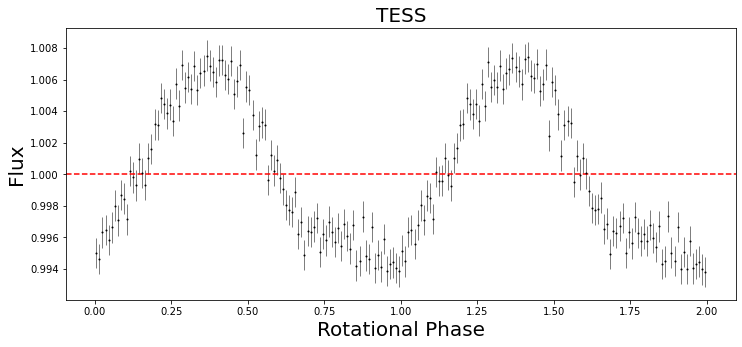

In [5]:
plt.figure(figsize=(12, 5))

plt.title('TESS', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, TESS_flux, yerr=TESS_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [14]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1, testval=0.05)
    radius = 50
    lat = pm.Uniform("lat", lower=0.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=TESS_flux_err, observed=TESS_flux)

In [7]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, contrast]


message: Optimization terminated successfully.
logp: -926.6681568884328 -> 1028.992727352944


In [8]:
keys = ["contrast", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.13819
lat          72.44738
lon          45.33533
inc          13.21241


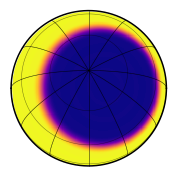

In [15]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.13819, radius=50, lat=72.44738, lon=45.33533)
map.inc = 13.21241
map.show()

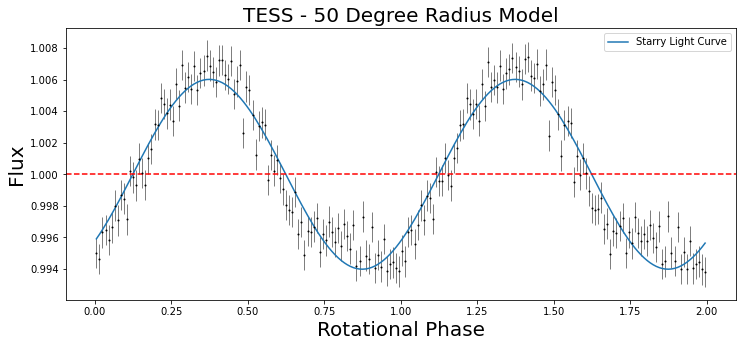

In [29]:
TESS_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('TESS - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, TESS_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, TESS_flux, yerr=TESS_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [30]:
residuals = (TESS_flux - TESS_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.7346996913448365

# LT

In [32]:
# importing the data into arrays
# first column of the data file is phase data
LTPhaseHalf = np.loadtxt("GD356LT.dat", usecols=(0))
LTPhase = np.concatenate((LTPhaseHalf, LTPhaseHalf+1))
# second column of the data file is flux data
LTFluxHalf = np.loadtxt("GD356LT.dat", usecols=(1))
LTFlux = np.concatenate((LTFluxHalf+1, LTFluxHalf+1))
# third column of the data file is flux error
LTErrorHalf = np.loadtxt("GD356LT.dat", usecols=(2))
LTError = np.concatenate((LTErrorHalf, LTErrorHalf))

In [33]:
meanPhase, meanFlux, meanError = mean_data(LTPhase, LTFlux, LTError, 200)

LT_flux = meanFlux
LT_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

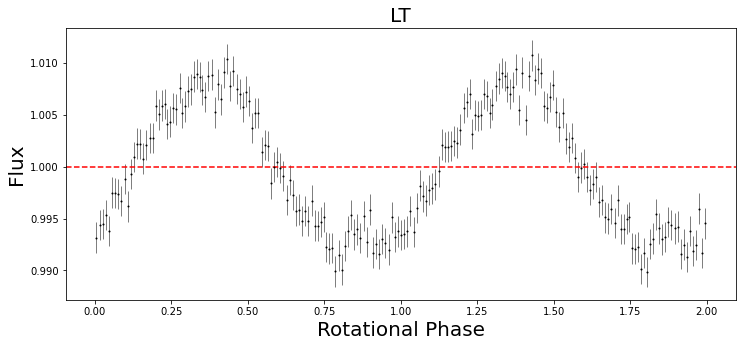

In [34]:
plt.figure(figsize=(12, 5))

plt.title('LT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, LT_flux, yerr=LT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [35]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=LT_flux_err, observed=LT_flux)

In [36]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 99.82243855197159 -> 1014.6195495448547


In [37]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.18184
lon          48.85461


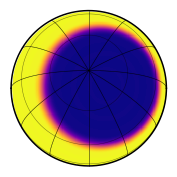

In [38]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.18184, radius=50, lat=72.44738, lon=48.85461)
map.inc = 13.21241
map.show()

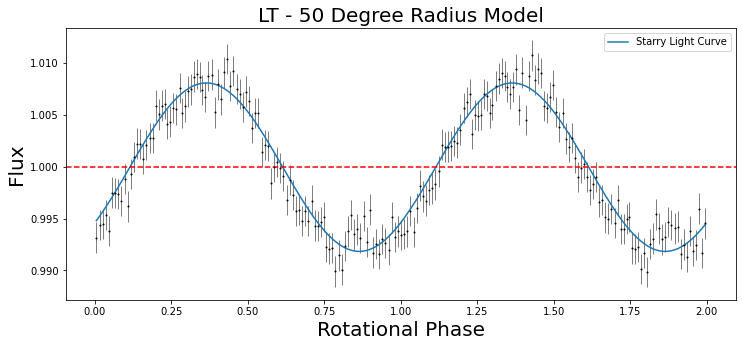

In [39]:
LT_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('LT - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, LT_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, LT_flux, yerr=LT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [40]:
residuals = (LT_flux - LT_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.0749351660832702

# PTO

In [41]:
# importing the data into arrays
# first column of the data file is phase data
PTO_PhaseHalf = np.loadtxt("GD356PTO.dat", usecols=(0))
PTO_Phase = np.concatenate((PTO_PhaseHalf, PTO_PhaseHalf+1))
# second column of the data file is flux data
PTO_FluxHalf = np.loadtxt("GD356PTO.dat", usecols=(1))
PTO_Flux = np.concatenate((PTO_FluxHalf+1, PTO_FluxHalf+1))
# third column of the data file is flux error
PTO_ErrorHalf = np.loadtxt("GD356PTO.dat", usecols=(2))
PTO_Error = np.concatenate((PTO_ErrorHalf, PTO_ErrorHalf))

In [42]:
meanPhase, meanFlux, meanError = mean_data(PTO_Phase, PTO_Flux, PTO_Error, 200)

PTO_flux = meanFlux
PTO_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

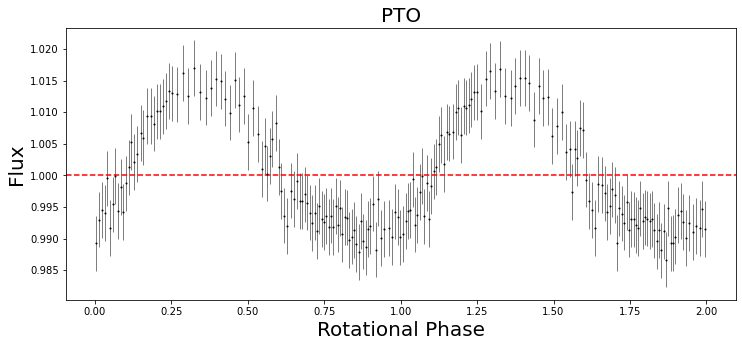

In [43]:
plt.figure(figsize=(12, 5))

plt.title('PTO', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, PTO_flux, yerr=PTO_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [44]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=PTO_flux_err, observed=PTO_flux)

In [45]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 611.0088714308523 -> 858.7046880303859


In [46]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.25790
lon          51.71671


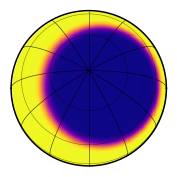

In [47]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.25790, radius=50, lat=72.44738, lon=51.71671)
map.inc = 13.21241
map.show()

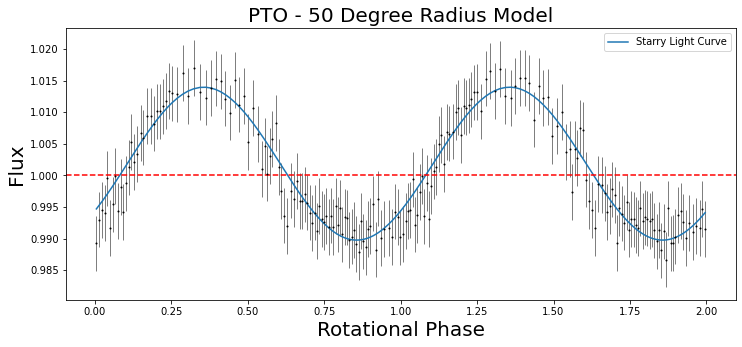

In [48]:
PTO_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('PTO - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, PTO_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, PTO_flux, yerr=PTO_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [49]:
residuals = (PTO_flux - PTO_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

0.39706371394336515

# WHT

In [50]:
# importing the data into arrays
# first column of the data file is phase data
WHT_PhaseHalf = np.loadtxt("GD356WHT.dat", usecols=(0))
WHT_Phase = np.concatenate((WHT_PhaseHalf, WHT_PhaseHalf+1))
# second column of the data file is flux data
WHT_FluxHalf = np.loadtxt("GD356WHT.dat", usecols=(1))
WHT_Flux = np.concatenate((WHT_FluxHalf+1, WHT_FluxHalf+1))
# third column of the data file is flux error
WHT_ErrorHalf = np.loadtxt("GD356WHT.dat", usecols=(2))
WHT_Error = np.concatenate((WHT_ErrorHalf, WHT_ErrorHalf))

In [51]:
meanPhase, meanFlux, meanError = mean_data(WHT_Phase, WHT_Flux, WHT_Error, 200)

WHT_flux = meanFlux
WHT_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

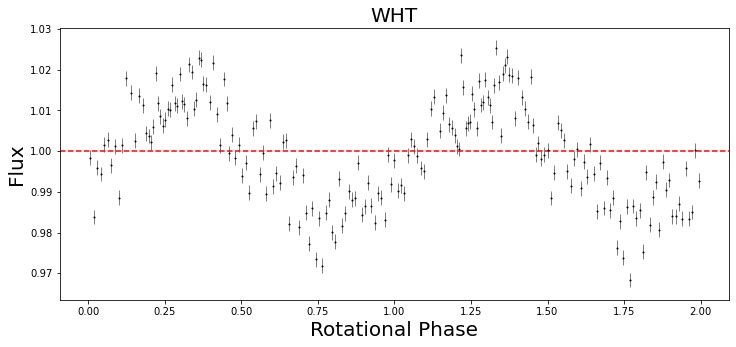

In [52]:
plt.figure(figsize=(12, 5))

plt.title('WHT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, WHT_flux, yerr=WHT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [53]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=WHT_flux_err, observed=WHT_flux)

In [54]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -3084.7868073024574 -> -79.32270090498116


In [55]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.30791
lon          68.29740


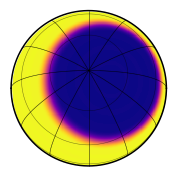

In [56]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.30791, radius=50, lat=72.44738, lon=68.29740)
map.inc = 13.21241
map.show()

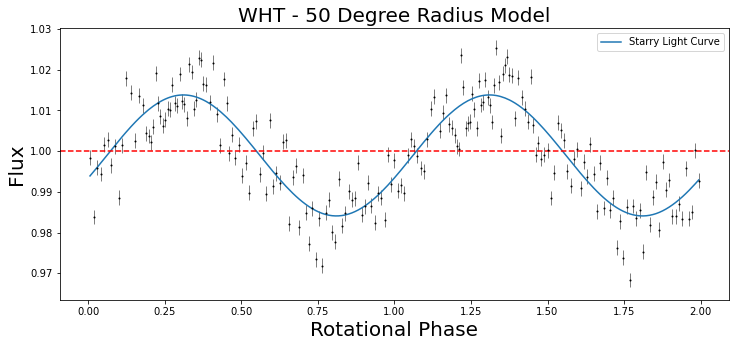

In [57]:
WHT_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('WHT - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, WHT_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, WHT_flux, yerr=WHT_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [58]:
residuals = (WHT_flux - WHT_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

11.804347919925139

# ZTF-r

In [59]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356ZTFR.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356ZTFR.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

ZTFr_flux = meanFlux
ZTFr_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

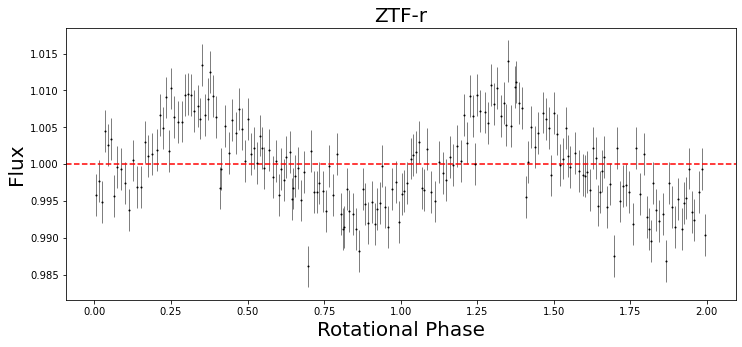

In [60]:
plt.figure(figsize=(12, 5))

plt.title('ZTF-r', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFr_flux, yerr=ZTFr_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [61]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ZTFr_flux_err, observed=ZTFr_flux)

In [62]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 675.506816764168 -> 848.980848349277


In [63]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.14747
lon          55.01358


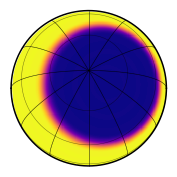

In [64]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.14747, radius=50, lat=72.44738, lon=55.01358)
map.inc = 13.21241
map.show()

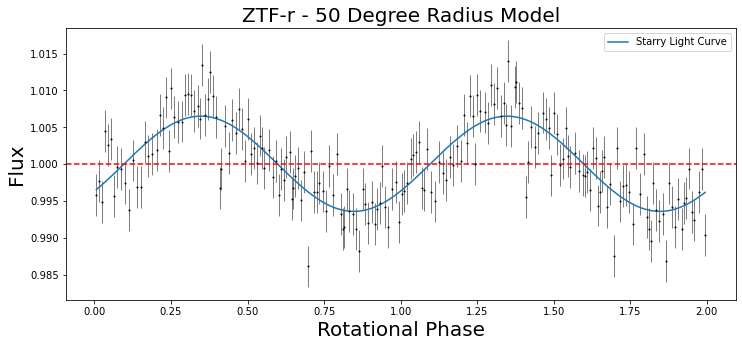

In [65]:
ZTFr_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('ZTF-r - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, ZTFr_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFr_flux, yerr=ZTFr_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [66]:
residuals = (ZTFr_flux - ZTFr_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.3945788385042737

# ZTF-g

In [7]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356ZTFG.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356ZTFG.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

ZTFg_flux = meanFlux
ZTFg_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

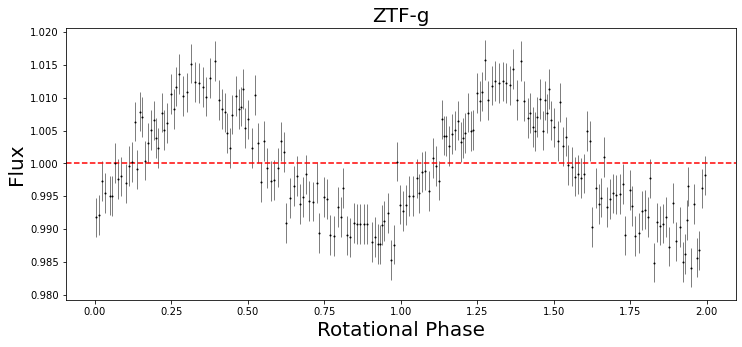

In [8]:
plt.figure(figsize=(12, 5))

plt.title('ZTF-g', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFg_flux, yerr=ZTFg_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [69]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=ZTFg_flux_err, observed=ZTFg_flux)

In [70]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 463.81420293436116 -> 870.9093020060288


In [71]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.22967
lon          53.59661


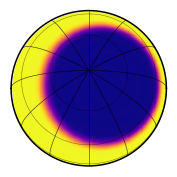

In [6]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.22967, radius=50, lat=72.44738, lon=53.59661)
map.inc = 13.21241
map.show()

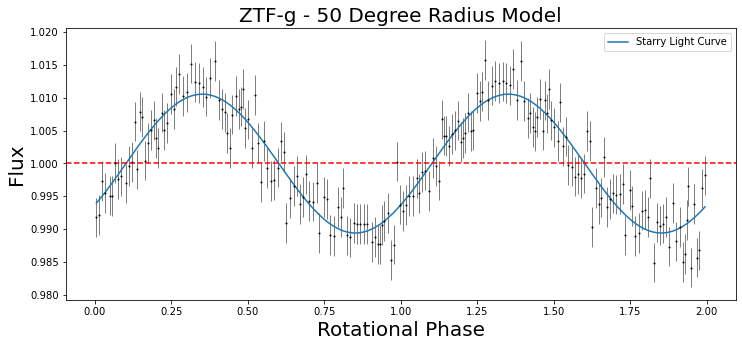

In [9]:
ZTFg_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('ZTF-g - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, ZTFg_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, ZTFg_flux, yerr=ZTFg_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [10]:
residuals = (ZTFg_flux - ZTFg_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.0434935713481204

# NUV

In [11]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV_flux = meanFlux
NUV_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

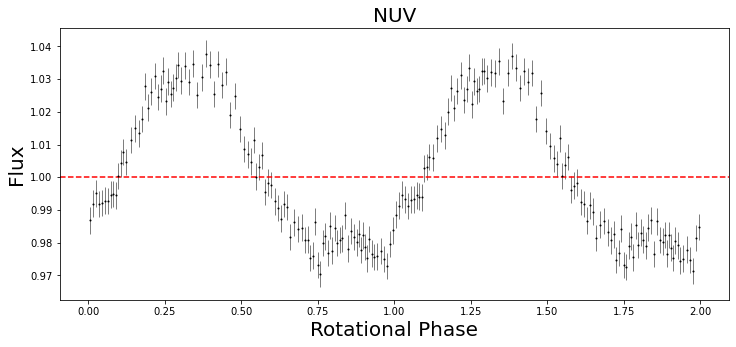

In [12]:
plt.figure(figsize=(12, 5))

plt.title('NUV', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV_flux, yerr=NUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [13]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV_flux_err, observed=NUV_flux)

In [14]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -1351.7170169124795 -> 748.1951109104177


In [15]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.50339
lon          59.79912


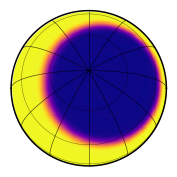

In [16]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.50339, radius=50, lat=72.44738, lon=59.79912)
map.inc = 13.21241
map.show()

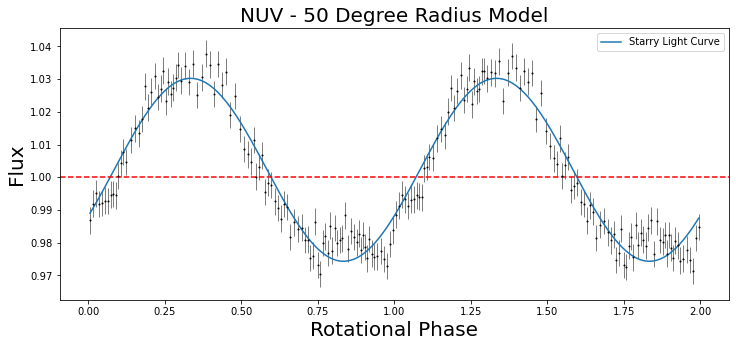

In [17]:
NUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV_flux, yerr=NUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [18]:
residuals = (NUV_flux - NUV_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.7069477085348412

# NUV (2550 - 2950)

In [19]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(2550_2950).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(2550_2950).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV3_flux = meanFlux
NUV3_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

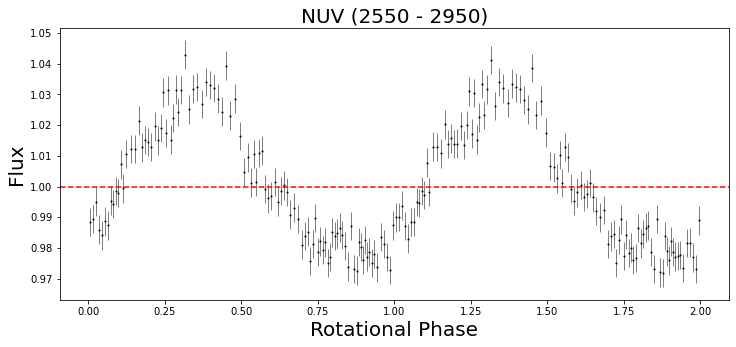

In [20]:
plt.figure(figsize=(12, 5))

plt.title('NUV (2550 - 2950)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV3_flux, yerr=NUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [21]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV3_flux_err, observed=NUV3_flux)

In [22]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -624.157614822395 -> 738.0449815421872


In [23]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.48240
lon          52.87505


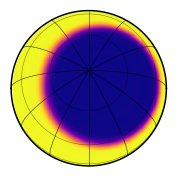

In [24]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.48240, radius=50, lat=72.44738, lon=52.87505)
map.inc = 13.21241
map.show()

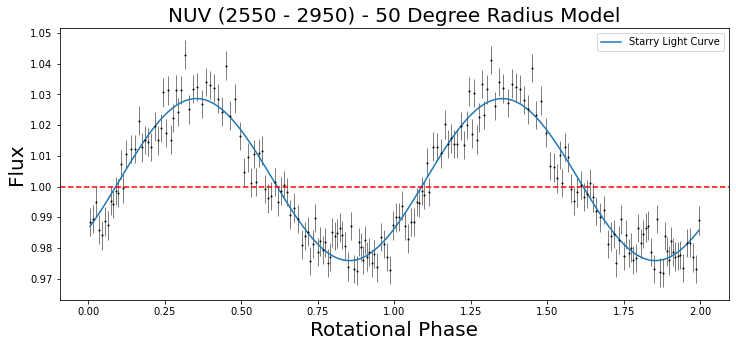

In [25]:
NUV3_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (2550 - 2950) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV3_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV3_flux, yerr=NUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [26]:
residuals = (NUV3_flux - NUV3_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.5397810126523819

# NUV (2150 - 2550)

In [27]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(2150_2550).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(2150_2550).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV2_flux = meanFlux
NUV2_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

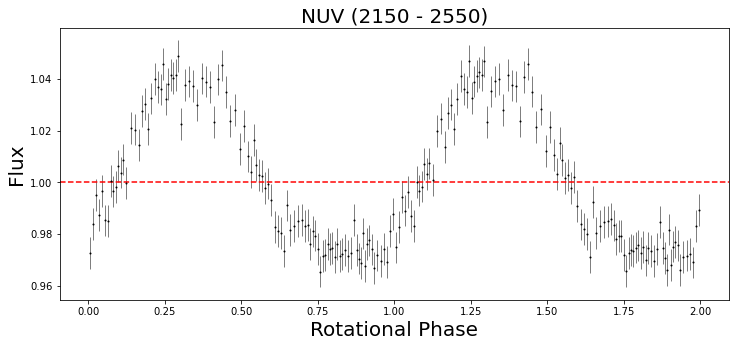

In [28]:
plt.figure(figsize=(12, 5))

plt.title('NUV (2150 - 2550)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV2_flux, yerr=NUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [29]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV2_flux_err, observed=NUV2_flux)

In [30]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -783.7143337049039 -> 697.7589401662227


In [31]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.58971
lon          60.90157


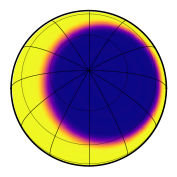

In [32]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.58971, radius=50, lat=72.44738, lon=60.90157)
map.inc = 13.21241
map.show()

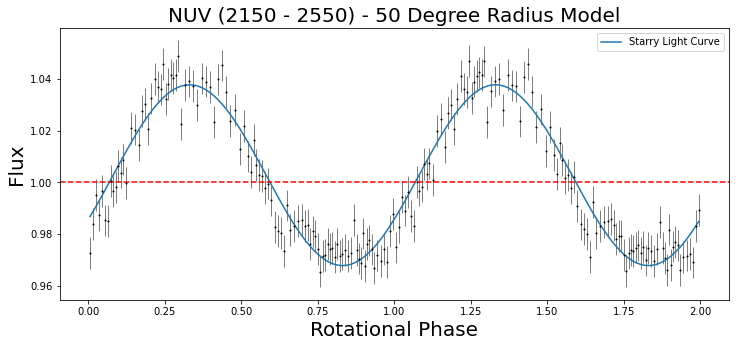

In [33]:
NUV2_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (2150 - 2550) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV2_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV2_flux, yerr=NUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [34]:
residuals = (NUV2_flux - NUV2_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.3744977833294454

# NUV (1630 - 2150)

In [35]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTNUV(1630_2150).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTNUV(1630_2150).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

NUV1_flux = meanFlux
NUV1_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

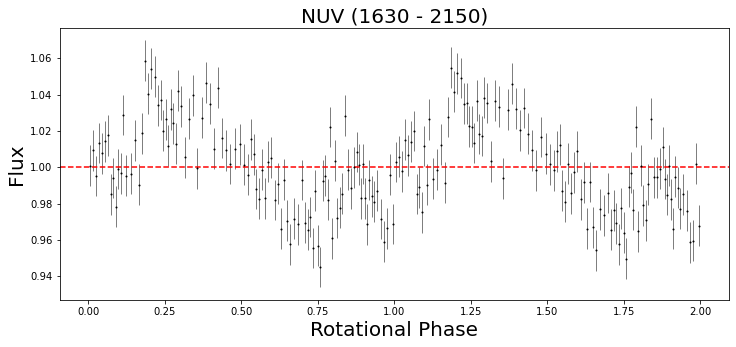

In [36]:
plt.figure(figsize=(12, 5))

plt.title('NUV (1630 - 2150)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV1_flux, yerr=NUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [37]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=NUV1_flux_err, observed=NUV1_flux)

In [38]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 245.79943382374944 -> 484.65881204047406


In [39]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.45969
lon          78.02163


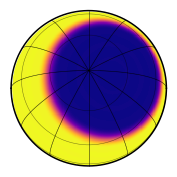

In [40]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.45969, radius=50, lat=72.44738, lon=78.02163)
map.inc = 13.21241
map.show()

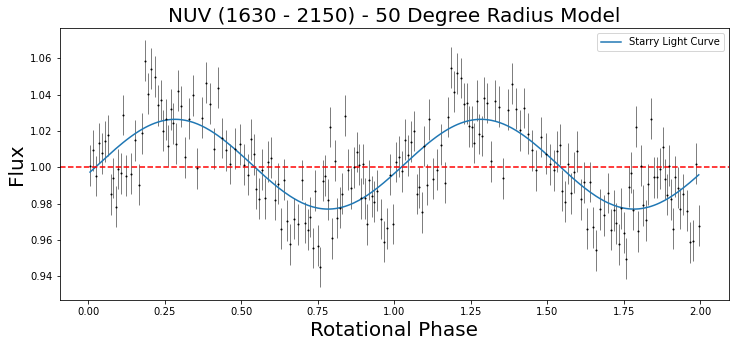

In [41]:
NUV1_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('NUV (1630 - 2150) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, NUV1_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, NUV1_flux, yerr=NUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [42]:
residuals = (NUV1_flux - NUV1_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.317300438046135

# FUV

In [7]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV.dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV.dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV_flux = meanFlux
FUV_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

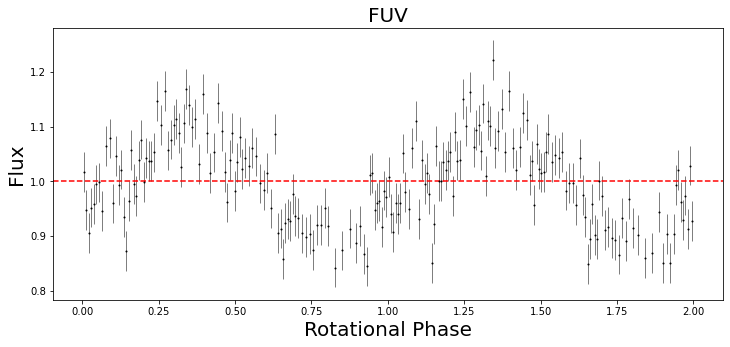

In [8]:
plt.figure(figsize=(12, 5))

plt.title('FUV', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [45]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV_flux_err, observed=FUV_flux)

In [46]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 0.4218655111136762 -> 293.8902590775932


In [47]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      1.03140
lon          58.15142


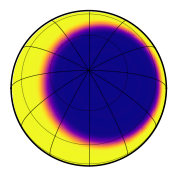

In [6]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=50, lat=72.44738, lon=58.15142)
map.inc = 13.21241
map.show()

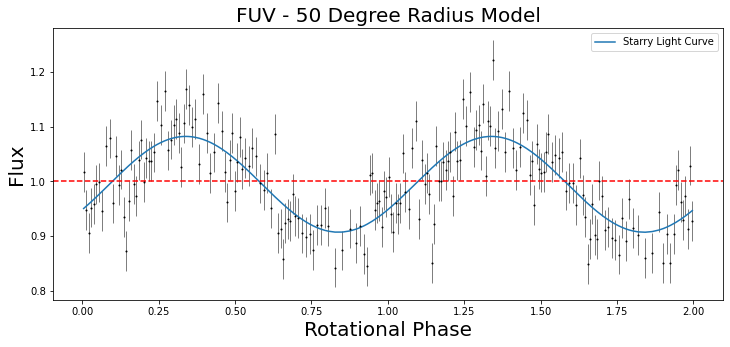

In [9]:
FUV_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV_flux, yerr=FUV_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [10]:
residuals = (FUV_flux - FUV_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.884662054041278

# FUV (1520 - 1715)

In [11]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1520_1715).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1520_1715).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV3_flux = meanFlux
FUV3_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

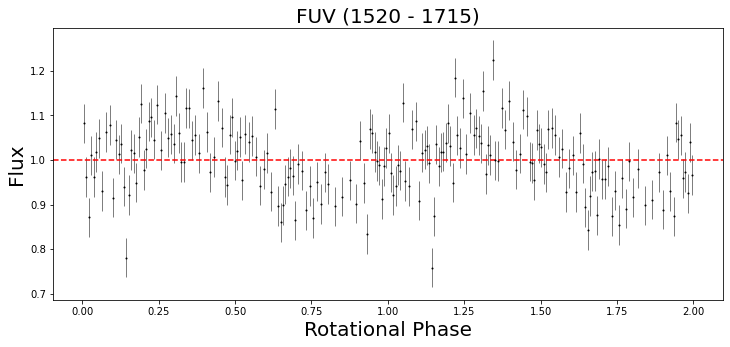

In [12]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1520 - 1715)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV3_flux, yerr=FUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [13]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV3_flux_err, observed=FUV3_flux)

In [14]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 144.69371403591975 -> 228.95463375210733


In [15]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.83104
lon          65.94332


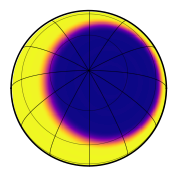

In [16]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.83104, radius=50, lat=72.44738, lon=65.94332)
map.inc = 13.21241
map.show()

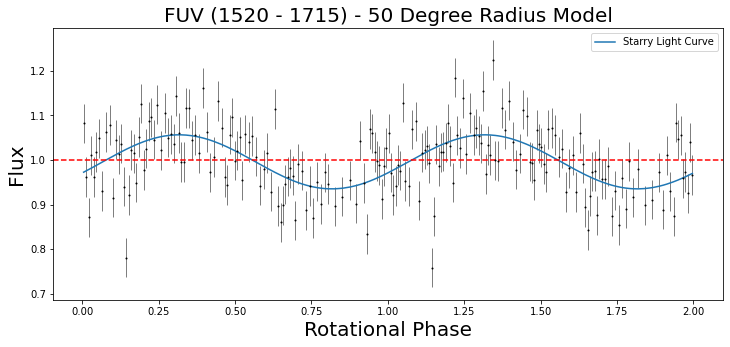

In [17]:
FUV3_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1520 - 1715) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV3_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV3_flux, yerr=FUV3_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [18]:
residuals = (FUV3_flux - FUV3_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

2.137938743855822

# FUV (1330 - 1520)

In [13]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1330_1520).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1330_1520).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV2_flux = meanFlux
FUV2_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

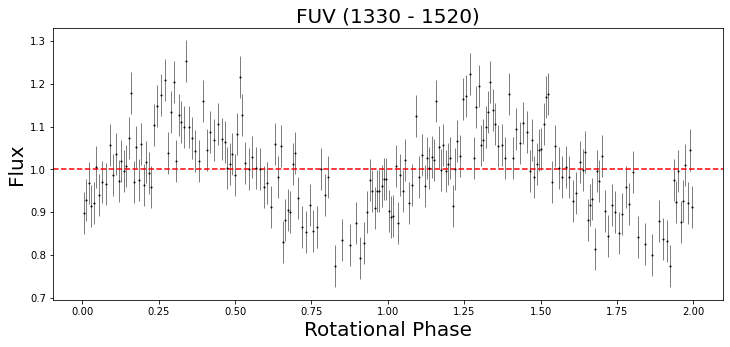

In [14]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1330 - 1520)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV2_flux, yerr=FUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [15]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=10, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV2_flux_err, observed=FUV2_flux)

In [16]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: 30.803560745785294 -> 258.0659531439044


In [17]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      1.10725
lon          56.23307


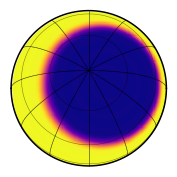

In [18]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=50, lat=72.44738, lon=56.23264)
map.inc = 13.21241
map.show()

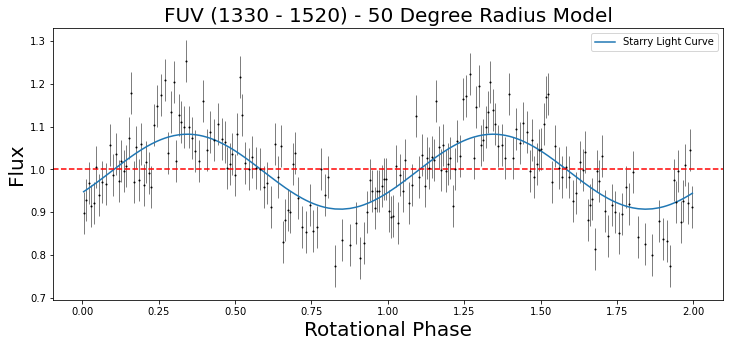

In [19]:
FUV2_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1330 - 1520) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV2_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV2_flux, yerr=FUV2_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [20]:
residuals = (FUV2_flux - FUV2_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

1.7254495951106248

# FUV (1120 - 1330)

In [21]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

FUV1_flux = meanFlux
FUV1_flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

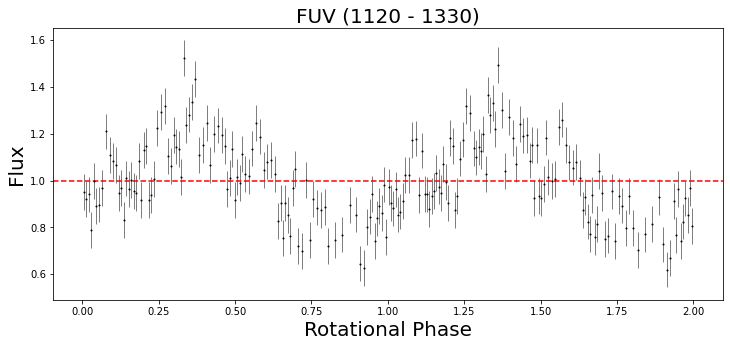

In [22]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1120 - 1330)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV1_flux, yerr=FUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [29]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=2, testval=0.1)
    radius = 50
    lat = 72.44738
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 13.21241
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=FUV1_flux_err, observed=FUV1_flux)

In [30]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -178.08178701586058 -> 114.01476973954654


In [31]:
keys = ["contrast", "lon"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      1.33770
lon          50.75068


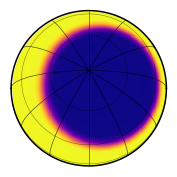

In [23]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=50, lat=72.44738, lon=50.75068)
map.inc = 13.21241
map.show()

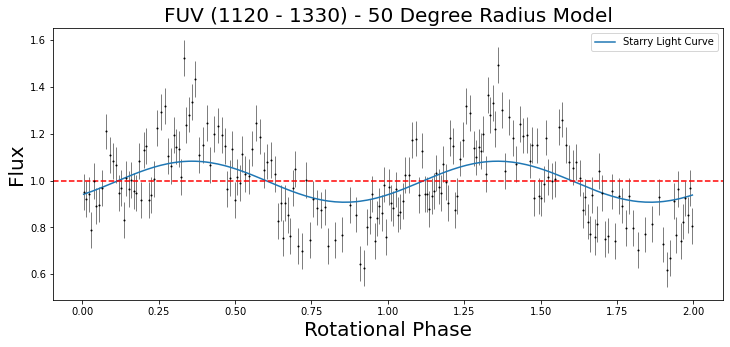

In [24]:
FUV1_newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120 - 1330) - 50 Degree Radius Model', fontsize=20)
plt.plot(meanPhase, FUV1_newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, FUV1_flux, yerr=FUV1_flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [25]:
residuals = (FUV1_flux - FUV1_newFlux)/meanError
chi_squared = np.sum(residuals**2)
reduced = chi_squared/(200-5)
reduced

3.126070533208673